In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import sparse, special, stats

# Machine Learning
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

# Parallel Processing
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

# Data Structure and Iteration
from collections import defaultdict
from itertools import combinations, permutations

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# System and Utilities
import os
import re
import random
import warnings
import contextlib
import itertools
from typing import List, Set, Dict, Tuple, Optional
import json

# treat imbalanced data
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Grove
import sys
sys.path.append('../src')
from grove_model import Grove_binary

# 데이터 불러오기 (KMLE 데이터)

In [10]:
# KMLE
url = 'https://github.com/novicedata/Paper/blob/main/Grove_CAT/data/KMLE.txt?raw=true'
data = pd.read_csv(url, sep = '\t', header=None)
data.columns = [f'Q{i}' for i in range(1, 361)]

In [11]:
data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q351,Q352,Q353,Q354,Q355,Q356,Q357,Q358,Q359,Q360
0,1,1,1,0,1,1,1,1,1,1,...,0,1,1,0,0,1,1,1,1,0
1,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,0,1,1,1,0
2,1,1,1,0,1,1,1,1,1,1,...,1,1,1,0,0,0,1,1,0,1
3,1,1,1,0,1,1,1,1,1,1,...,0,1,1,0,0,1,1,1,0,0
4,1,1,1,0,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,1,1,1,0,1,1,1,1,1,0,...,0,1,1,0,1,0,1,1,1,0
3255,1,1,1,0,1,1,1,1,1,1,...,0,1,1,0,0,1,1,0,0,0
3256,1,1,1,0,1,0,1,1,1,1,...,1,1,1,1,0,1,1,1,0,0
3257,1,1,1,0,1,1,0,1,1,1,...,0,1,1,1,0,1,1,1,0,0


# 데이터 정제

해당년도 채점 기준을 적용하여 모든 조건을 만족하는 경우만 Pass(1)로 코딩

In [4]:
# 데이터 형태 출력
print(f'raw : {data.shape}')
data.dropna(inplace=True)
print(f'After dropping NaN: {data.shape}')

# 각 구간별 점수 계산
data['score_1_20'] = data.iloc[:, 0:20].sum(axis=1)  # Q1-Q20 점수
data['score_21_80'] = data.iloc[:, 20:80].sum(axis=1)  # Q21-Q80 점수
data['score_81_360'] = data.iloc[:, 80:360].sum(axis=1)  # Q81-Q360 점수
data['score_total'] = data.iloc[:, 0:360].sum(axis=1)  # 전체 점수

# 각 구간별 Pass 여부 계산 (조건 만족 = True)
condition1 = data['score_1_20'] >= 8  # 첫 20문항 중 8개 이상
condition2 = data['score_21_80'] >= 24  # 중간 60문항 중 24개 이상
condition3 = data['score_81_360'] >= 112  # 마지막 280문항 중 112개 이상
condition4 = data['score_total'] >= 216  # 전체 360문항 중 216개 이상

# 모든 조건을 만족하는 경우만 Pass(1)로 코딩
data['final_result'] = (condition1 & condition2 & condition3 & condition4).astype(int)

# X와 y 분리
X = data.iloc[:, 0:360]  # 원본 문항 데이터
y = data['final_result']  # Pass/Fail 결과

# 결과 확인
print("\n첫 5개 데이터의 구간별 점수:")
print(data[['score_1_20', 'score_21_80', 'score_81_360', 'score_total', 'final_result']].head())

# Pass율 확인
pass_rate = (data['final_result'] == 1).mean() * 100
print(f"\n전체 Pass율: {pass_rate:.2f}%")

raw : (3259, 360)
After dropping NaN: (3259, 360)

첫 5개 데이터의 구간별 점수:
   score_1_20  score_21_80  score_81_360  score_total  final_result
0          18           51           222          291             1
1          17           39           206          262             1
2          15           43           199          257             1
3          17           49           207          273             1
4          18           39           192          249             1

전체 Pass율: 95.24%


In [5]:
y.value_counts()

final_result
1    3104
0     155
Name: count, dtype: int64

### SMOTE + ENN 적용

In [6]:
# SMOTE + ENN 적용
smote_enn = SMOTEENN(sampling_strategy=0.3, random_state = 42)  # 비율을 0.3 정도로 조정
X, y = smote_enn.fit_resample(X, y)

In [7]:
y.value_counts()

final_result
1    3101
0     927
Name: count, dtype: int64

# CATBoost 적합

In [8]:
def train_catboost(X_train, y_train, X_test, y_test,
                   max_depth=3,
                   n_estimators=100,
                   learning_rate=1,
                   subsample=0.5,
                   min_child_samples=1,
                   random_state=42,
                   auto_class_weights=None):
    """
    주어진 파라미터로 CatBoost 모델을 학습시키는 함수입니다.
    :param X_train: 학습 데이터
    :param y_train: 학습 데이터의 레이블
    :param X_test: 테스트 데이터
    :param y_test: 테스트 데이터의 레이블
    :param max_depth: 트리의 최대 깊이 (default: 3)
    :param n_estimators: 생성할 트리의 수 (default: 100)
    :param learning_rate: 학습률 (default: 1)
    :param colsample_bylevel: 각 레벨에서 사용할 특성의 비율 (default: 0.5)
    :param subsample: 각 트리가 사용할 데이터의 비율 (default: 0.5)
    :param min_child_samples: 리프 노드의 최소 샘플 수 (default: 1)
    :param random_state: 랜덤 시드 (default: 42)
    :param auto_class_weights: 클래스 가중치 자동 설정 (default: None)
    :return: 학습된 모델과 파라미터
    """
    # 모델 파라미터 설정
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': learning_rate,
        'depth': max_depth,
        'subsample': subsample,
        'grow_policy' : 'Lossguide',
        'random_seed': random_state,
        'iterations': n_estimators,
        'verbose': False,
        'thread_count': -1,
        'auto_class_weights': auto_class_weights
    }

    # Pool 생성
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)

    # 모델 생성 및 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=test_pool,
              verbose=False)

    # 학습 데이터에 대한 예측 및 AUC 계산
    y_pred_train = model.predict_proba(train_pool)[:, 1]
    train_auc = roc_auc_score(y_train, y_pred_train)
    print(f"Final model AUC on train data: {train_auc}")

    # 테스트 데이터에 대한 예측 및 AUC 계산
    y_pred_test = model.predict_proba(test_pool)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_test)
    print(f"Final model AUC on test data: {test_auc}")

    return model, params


# Grove 코드

### 초기화 및 캐싱 메커니즘:

'__init__' 함수에서 세 가지 캐시 딕셔너리를 초기화:

1. _path_cache: 트리 경로 정보를 저장

2. _feature_cache: 각 트리가 사용하는 특성(feature) 집합을 저장

3. _prediction_cache: 트리별 예측값을 저장




### 트리 구조 분석:

get_tree_paths: 트리의 모든 가능한 경로와 각 경로에서 사용하는 특성들을 추출.

extract_features_from_node: 재귀적으로 트리 노드를 순회하며 사용된 특성들을 추출.

extract_tree_features: CatBoost 모델을 JSON 형식으로 저장하고 각 트리별로 사용된 모든 특성을 분석.

get_path_features_from_node: 특정 노드에서 시작하여 가능한 모든 경로의 특성 집합을 추출.


### 메모리 최적화:

optimize_numeric_dtypes: 수치형 데이터의 데이터 타입을 최적화하여 메모리 사용량을 줄임.

_temporary_pool: 컨텍스트 매니저를 통해 메모리를 효율적으로 관리.


### 트리 조합 분석:

calculate_item_range: 주어진 트리 조합에서 사용자가 받게 될 최소/최대 문항 수를 계산.

find_optimal_tree_groups: 지정된 트리 개수 범위를 만족하고 필수 특성을 포함하는 모든 가능한 트리 조합을 찾음.

get_tree_predictions: 메모리 효율적인 방식으로 특정 트리의 예측값을 계산.


### 병렬 처리 및 결과 생성:

process_tree_groups_batch: 배치 단위로 트리 그룹을 처리하여 성능 지표를 계산.

create_results_dataframe: 분석 결과를 정리하여 데이터프레임으로 변환.


### 메인 분석 프로세스 (analyze 함수):

입력 데이터와 매개변수 검증

트리별 특성 추출

트리별 예측값 계산

유효한 트리 조합 탐색

병렬 처리를 통한 조합별 성능 평가

AUC 기준 상위 조합 필터링

최소/최대 문항 수 계산

결과 정리 및 반환


### 예측 기능 (predict 함수):

선택된 트리 조합만을 사용하여 학습 및 테스트 데이터에 대한 예측을 수행.

각 트리의 예측값을 합산한 후 시그모이드 함수를 적용하여 확률값으로 변환.

# Fig. 7.
### 데이터 분할:

전체 데이터를 테스트 세트(20%), 학습 세트(40%), 검증 세트(40%)로 분할.
                                       

### CatBoost 모델 초기 학습:

최대 깊이 10, 트리 개수 6개의 CatBoost 모델을 학습.
학습률(learning_rate)은 0.01로 설정.


### 최적 임계값 계산 함수 정의:

optimal_threshold 함수는 ROC 곡선을 기반으로 최적의 분류 임계값을 찾음.
이 임계값에서의 정확도(accuracy)도 함께 계산.


### Grove 분석 수행:

Grove 클래스를 사용해 분석을 실행.
3개부터 4개 까지의 트리 조합을 분석합니다.
Grove 분석 결과를 바탕으로 검증 세트와 테스트 세트에 대한 성능을 평가.
각 트리 조합별로 항목 수, AUC, 정확도를 저장.


### CatBoost 모델 추가 평가:

Grove에서 찾은 최대 항목 수까지 반복하며 다양한 트리 개수의 모델을 평가.
각 반복마다 새로운 CatBoost 모델을 지정된 트리 수로 학습.
학습 및 테스트 세트에 대한 AUC와 정확도를 계산.
최적 임계값도 함께 저장.


### Decision Tree 모델 평가:

같은 범위에서 다양한 깊이의 Decision Tree 모델을 학습.
CatBoost와 마찬가지로 성능 지표를 계산하고 저장.


### 결과 시각화:

4 개의 서브플롯으로 구성된 그래프를 생성:

상단: ROC-AUC 점수 비교 ( 왼쪽은 train/vlaid set, 오른쪽은 test set )
하단: 정확도(Accuracy) 비교 ( 왼쪽은 train/vlaid set, 오른쪽은 test set )


각 그래프에는 세 가지 모델(CatBoost, Decision Tree, Grove)의 학습/검증/테스트 성능이 표시.

x축은 "사람당 최대 항목 수"를 나타냄.


Train set size: 1611
Validation set size: 1611
Test set size: 806
Final model AUC on train data: 0.9979360490392141
Final model AUC on test data: 0.9944161552857206
Grove model evaluation...
Initializing analysis...
Number of trees: 6
Extracting tree features...
Step 1: Calculating predictions for each tree...
Step 2: Finding optimal tree groups...
Processed 10 batches out of 35
Processed 20 batches out of 35
Processed 30 batches out of 35
Filtered to top 35 results based on 100% percentile
Calculating min/max items for filtered results...
Processing 35 results...
Initial combinations: 35
After removing duplicates: 35
Processing completed. Found 35 unique combinations.
Final Combinations : 35
CatBoost model evaluation...
Decision Tree model evaluation...
Done 



/tmp/ipykernel_13306/1958730472.py:186: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(unique_tree_counts))


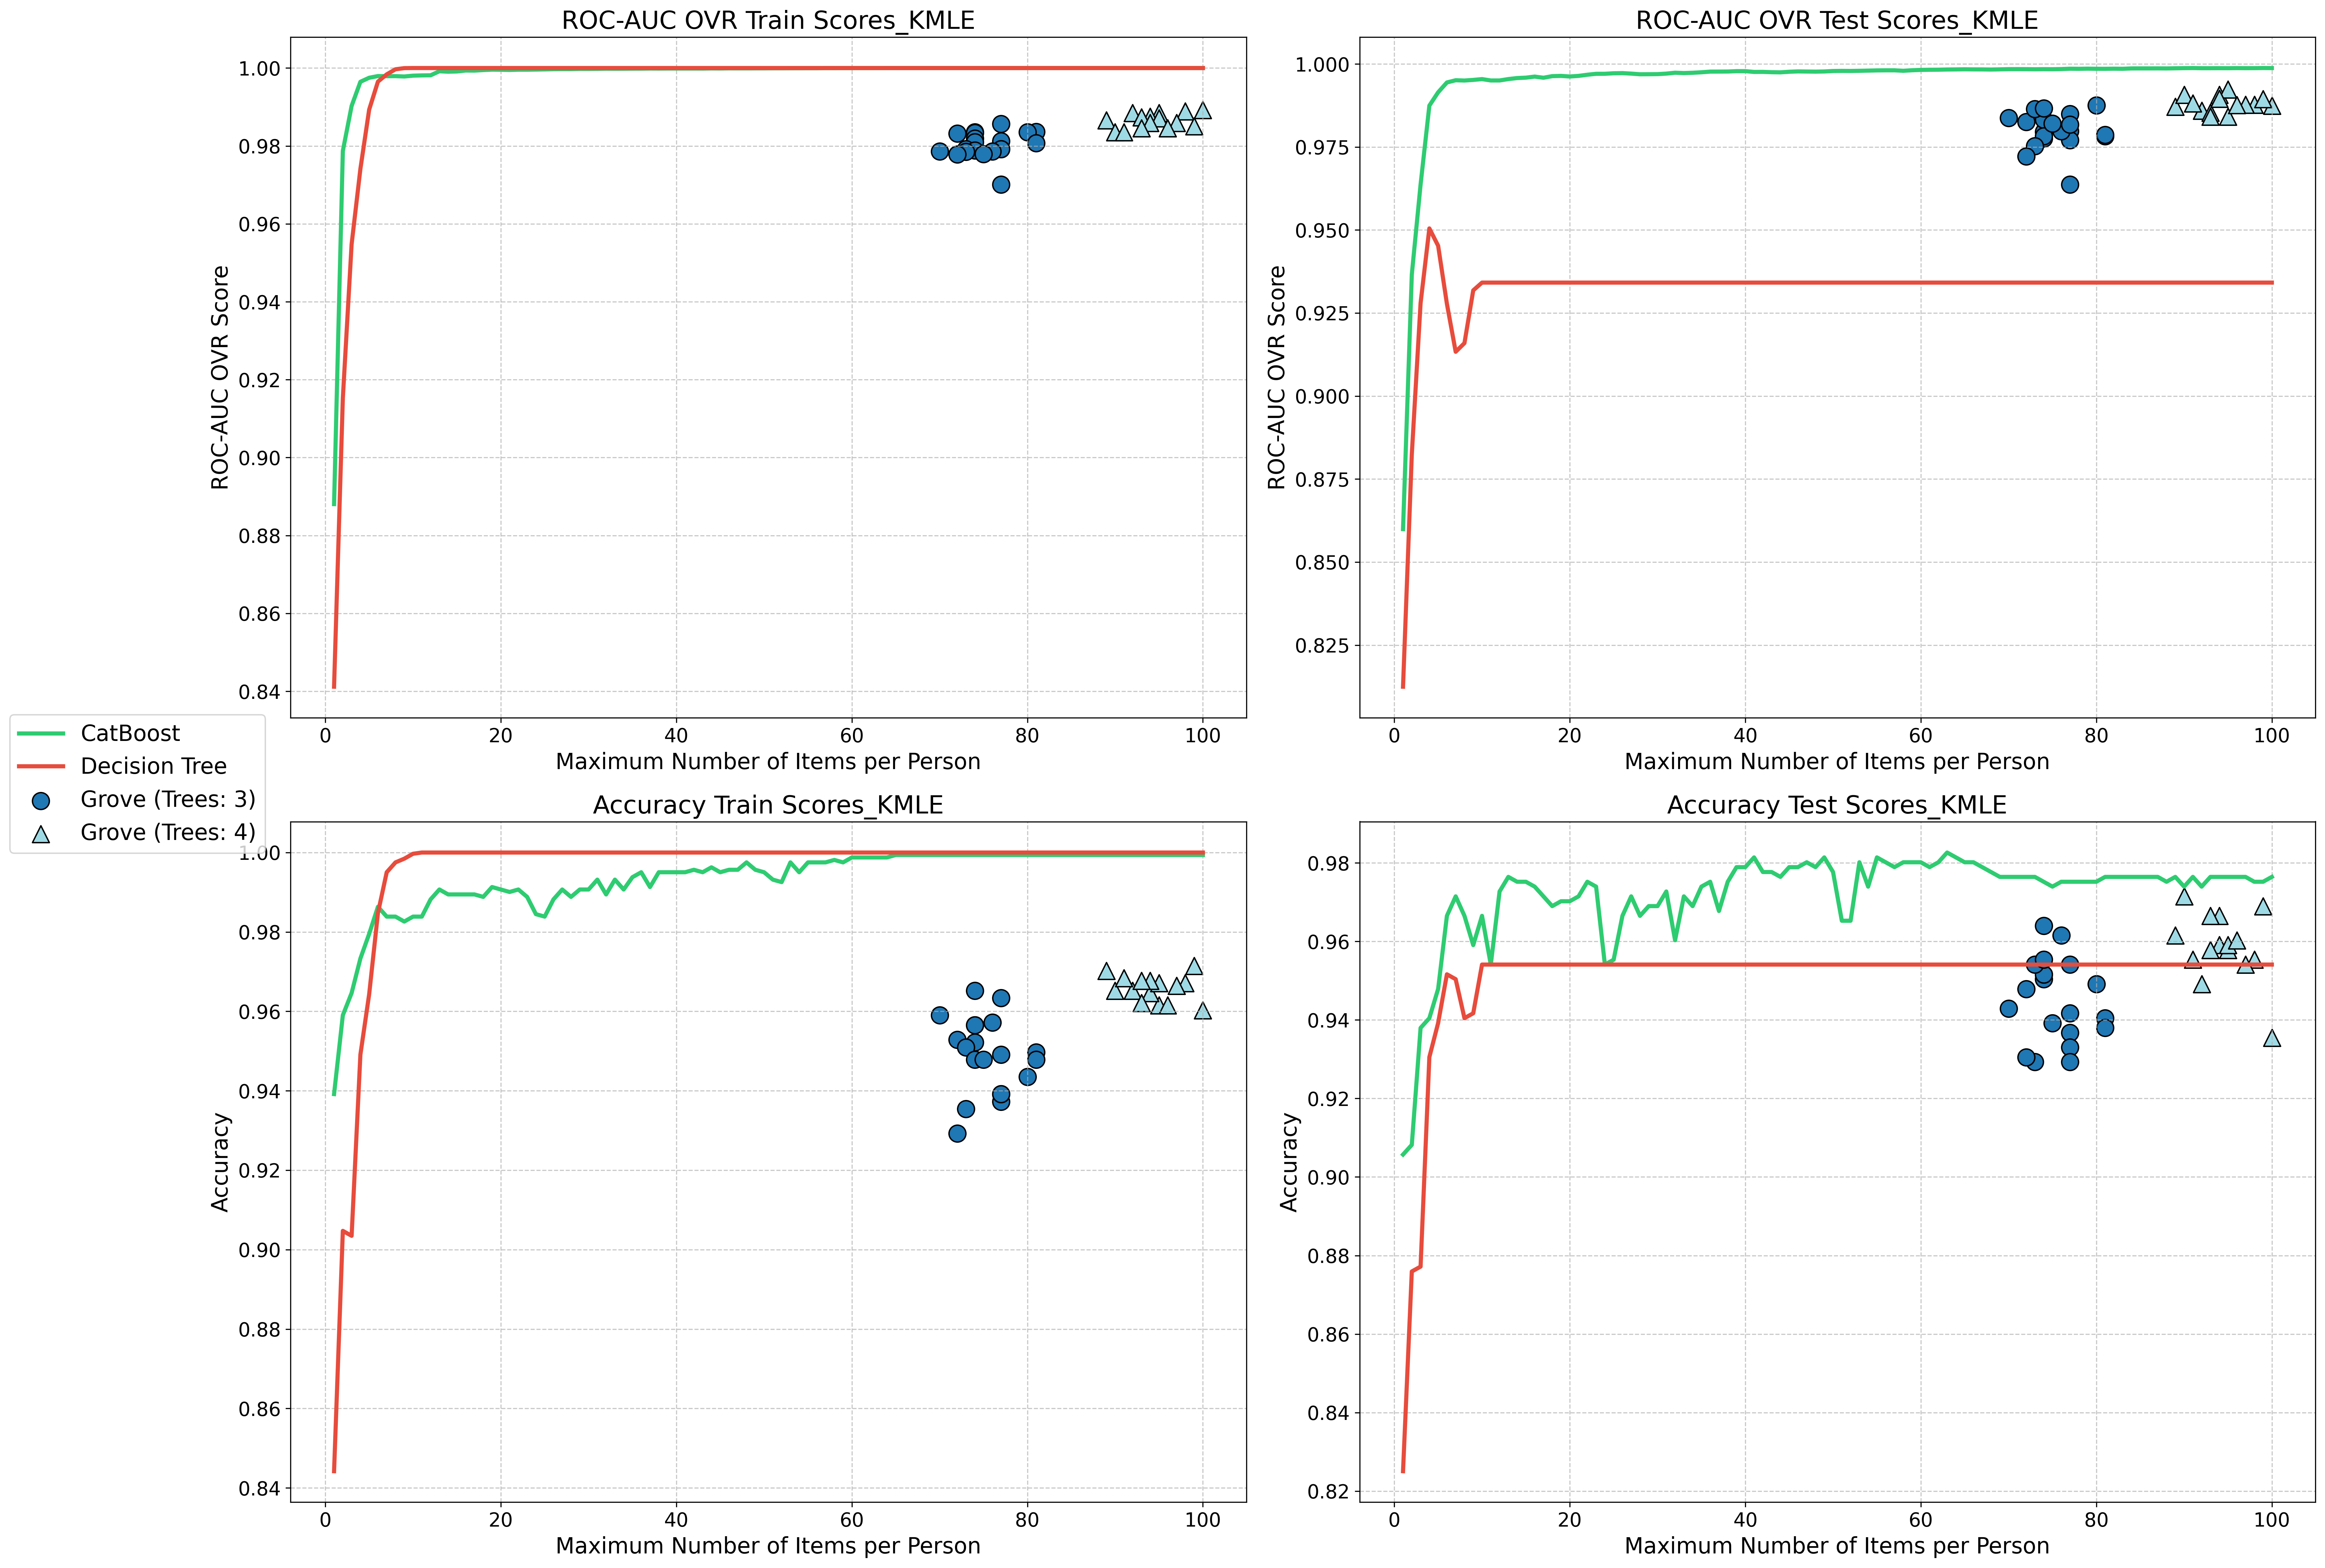

In [9]:
# 먼저 test set 분리 (전체의 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 80%의 데이터를 학습용/검증용 데이터로, 나머지 20%는 테스트 데이터로 분리

# 남은 데이터에서 train과 validation을 50:50으로 분리 (전체 기준으로는 80:20이 됨)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# 나머지 80%의 데이터(X_temp, y_temp)를 학습용과 검증용으로 50:50 비율로 나누어, 최종적으로 전체 데이터 기준으로 60% 학습, 20% 검증이 되도록 설정

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")
# 각 데이터 세트의 크기를 출력

# 모델 설정
trees_num = 6 # catboost 트리 개수
max_depth = 10 # catboost 트리 최대 깊이

# CatBoost 모델 학습
## 학습률, 트리 개수, 최대 깊이를 제외하고 모두 default값을 사용
model, param = train_catboost(X_train, y_train, X_test, y_test,
                            max_depth=max_depth,
                            n_estimators=trees_num,
                            learning_rate=0.01, # 학습률
                            subsample=1,
                            min_child_samples=1,
                            random_state=42,
                            auto_class_weights=None)
# CatBoost 모델을 학습시키기 위해 설정된 매개변수로 모델 학습

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)
# 학습용 및 테스트용 데이터를 CatBoost의 Pool 객체로 변환 (Pool 객체는 CatBoost에서 데이터를 효율적으로 처리하기 위한 구조)

def optimal_threshold(y_true, y_pred):
    """예측 확률에 대한 최적의 임계값을 찾고 해당 accuracy를 반환합니다"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # 해당 threshold에서의 accuracy 계산
    predictions = (y_pred >= optimal_threshold).astype(int)
    accuracy = accuracy_score(y_true, predictions)

    return optimal_threshold, accuracy
# ROC curve를 통해 최적의 임계값을 계산하고, 해당 임계값에서의 정확도를 반환하는 함수

# Grove 분석 먼저 실행
## 3개와 4개의 개별 트리로 이루어진 Grove 모델을 생성
print('Grove model evaluation...')
grove = Grove_binary()
results = grove.analyze(param, X_valid, y_valid, model,
                       tree_range=(3, 4),
                       n_jobs=-1, percentile=100)
# Grove 모델을 사용하여, 3개 또는 4개의 트리로 이루어진 모델을 분석
# `analyze` 함수에서 주어진 트리 수 범위 내에서 최적의 트리 조합을 찾고 성능을 평가

# Grove 결과 계산
grove_points = []
for _, row in results.iterrows():
    prediction_result = grove.predict(
        param,
        X_train=X_valid,
        y_train=y_valid,
        X_test=X_test,
        y_test=y_test,
        model=model,
        tree_indices=row['Tree Indices']
    )
    # Grove 모델에서 예측을 수행하여, 각 트리 인덱스 조합에 대해 예측값을 구함

    opt_threshold, train_acc = optimal_threshold(y_valid, prediction_result['train_probas'])
    test_acc = accuracy_score(y_test, (prediction_result['test_probas'] >= opt_threshold).astype(int))
    # 최적의 임계값을 구하고, train 및 test accuracy 계산

    grove_points.append({
        'n_items': row['Total Items'],
        'train_auc': row['Model Performance'],
        'test_auc': roc_auc_score(y_test, prediction_result['test_probas']),
        'train_acc': train_acc,
        'test_acc': test_acc
    })
# 예측 결과를 `grove_points` 리스트에 저장, 각 Grove 모델에서의 성능 정보 포함

# Grove에서 얻은 최대 Total Items 값을 이용하여 반복 범위 설정
max_items = max(point['n_items'] for point in grove_points)
iteration_range = range(1, max_items + 1, 1)
# Grove 모델에서 얻은 최대 `Total Items` 값을 기준으로 반복 범위를 설정

# 결과 저장을 위한 딕셔너리들
cat_results = {
    'train_auc': {}, 'test_auc': {},
    'train_acc': {}, 'test_acc': {},
    'thresholds': {}
}

dt_results = {
    'train_auc': {}, 'test_auc': {},
    'train_acc': {}, 'test_acc': {},
    'thresholds': {}
}
# CatBoost 및 Decision Tree 모델에 대한 평가 결과를 저장할 딕셔너리 생성

# CatBoost 모델 평가
print('CatBoost model evaluation...')
cat_models = {}
y_pred_tests = {}

for n_tree in iteration_range:
    # 새로운 모델 학습 (지정된 트리 수만큼만)
    params = param.copy()
    params['iterations'] = n_tree
    cat_model = CatBoostClassifier(**params)
    cat_model.fit(train_pool, verbose=False)
    cat_models[n_tree] = cat_model
    # 지정된 트리 수만큼 모델을 학습시키고, 트리 수별로 모델을 저장

    # 예측
    y_pred_train = cat_model.predict_proba(X_train)[:, 1]
    y_pred_test = cat_model.predict_proba(X_test)[:, 1]
    y_pred_tests[n_tree] = y_pred_test
    # 학습용 및 테스트용 데이터에 대해 예측값을 계산

    # AUC 점수 계산
    train_auc = roc_auc_score(y_train, y_pred_train)
    test_auc = roc_auc_score(y_test, y_pred_test)

    # 최적 임계값 찾기
    opt_threshold, train_acc = optimal_threshold(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, (y_pred_test >= opt_threshold).astype(int))
    # 최적 임계값을 찾고, 해당 임계값을 사용하여 정확도 계산

    # 결과 저장
    cat_results['train_auc'][n_tree] = train_auc
    cat_results['test_auc'][n_tree] = test_auc
    cat_results['train_acc'][n_tree] = train_acc
    cat_results['test_acc'][n_tree] = test_acc
    cat_results['thresholds'][n_tree] = opt_threshold
# CatBoost 모델에 대한 성능 (AUC, Accuracy 등)과 최적 임계값을 저장

# Decision Tree 학습 및 평가
print('Decision Tree model evaluation...')
dt_models = {}
dt_pred_tests = {}

for max_depth in iteration_range:
    dt_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt_model.fit(X_temp, y_temp)
    dt_models[max_depth] = dt_model
    # Decision Tree 모델을 트리 깊이 별로 학습시킴

    y_pred_train = dt_model.predict_proba(X_temp)[:, 1]
    y_pred_test = dt_model.predict_proba(X_test)[:, 1]
    dt_pred_tests[max_depth] = y_pred_test
    # 학습용 및 테스트용 데이터에 대해 예측값을 계산

    train_auc = roc_auc_score(y_temp, y_pred_train)
    test_auc = roc_auc_score(y_test, y_pred_test)

    opt_threshold, train_acc = optimal_threshold(y_temp, y_pred_train)
    test_acc = accuracy_score(y_test, (y_pred_test >= opt_threshold).astype(int))
    # AUC 점수 계산 및 최적 임계값을 사용하여 정확도 계산

    dt_results['train_auc'][max_depth] = train_auc
    dt_results['test_auc'][max_depth] = test_auc
    dt_results['train_acc'][max_depth] = train_acc
    dt_results['test_acc'][max_depth] = test_acc
    dt_results['thresholds'][max_depth] = opt_threshold
# Decision Tree 모델에 대한 성능 (AUC, Accuracy 등)과 최적 임계값을 저장

print('Done', '\n')
grove_x = [p['n_items'] for p in grove_points]
grove_tree_counts = [len(r['Tree Indices']) for _, r in results.iterrows()]
# Grove 모델의 `n_items`와 트리 개수를 각각 추출하여 그래프에서 사용할 값 생성

# 그래프의 스타일 설정
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12

# 여러 개의 그래프를 그리기 위한 2x2 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(24, 16), dpi=300)

# 트리 개수별로 색상과 모양 설정
unique_tree_counts = sorted(set(grove_tree_counts))
colors = cm.get_cmap('tab20', len(unique_tree_counts))
markers = ['o', '^', 's', 'D', 'P', 'X', '*', 'h', '+', 'x']
marker_dict = {count: markers[i % len(markers)] for i, count in enumerate(unique_tree_counts)}

# 그래프 설정 목록
graphs = [
    ('ROC-AUC OVR Train Scores_KMLE', 'train_auc', 'ROC-AUC OVR Score'),
    ('ROC-AUC OVR Test Scores_KMLE', 'test_auc', 'ROC-AUC OVR Score'),
    ('Accuracy Train Scores_KMLE', 'train_acc', 'Accuracy'),
    ('Accuracy Test Scores_KMLE', 'test_acc', 'Accuracy')
]

# 각 그래프에 대해 데이터 시각화
for ax, (title, metric_key, ylabel) in zip(axes.flatten(), graphs):
    ax.plot(cat_results[metric_key].keys(), cat_results[metric_key].values(),
            label='CatBoost', linestyle='-', color='#2ecc71', linewidth=3)
    ax.plot(dt_results[metric_key].keys(), dt_results[metric_key].values(),
            label='Decision Tree', linestyle='-', color='#e74c3c', linewidth=3)

    # Grove 포인트를 트리 개수별로 구분하여 scatter
    for idx, tree_count in enumerate(unique_tree_counts):
        xs = [x for x, c in zip(grove_x, grove_tree_counts) if c == tree_count]
        ys = [p[metric_key] for p, c in zip(grove_points, grove_tree_counts) if c == tree_count]
        ax.scatter(xs, ys, marker=marker_dict[tree_count], color=colors(idx),
                   label=f'Grove (Trees: {tree_count})', s=150, edgecolor='black')

    ax.set_title(title)
    ax.set_xlabel('Maximum Number of Items per Person')
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.7)

# 범례 설정
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.08, 0.5), fontsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('grove_tree_count_visualization_marker_KMLE.png', dpi=300, bbox_inches='tight')
plt.show()
# 각 모델의 성능을 시각적으로 비교하고, Grove 모델에서 얻은 트리 개수별로 성능 차이를 시각화하여 이미지 파일로 저장
